In [14]:
import codecs, json
import numpy as np
import pandas as pd
import glob
import pickle
from tqdm import tqdm

# CLEANSING

In [15]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from preprocess import prep
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# import StopWordRemoverFactory class
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
stoplist = pd.read_csv('stoplist.csv')

# Ambil Stopword bawaan
stop_factory = StopWordRemoverFactory().get_stop_words()

# Custom stopword
data = stoplist['list'].tolist()

dictionary = ArrayDictionary(data)
stopword = StopWordRemover(dictionary)

# MEMASUKKAN DATA LATIH DAN UJI

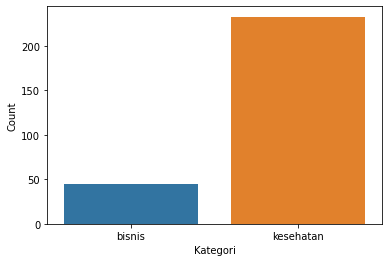

,Kategori,Count
1,kesehatan,233
0,bisnis,45


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt 
from nltk import FreqDist
data2 = pd.read_json('data-labelled (1).json')
# an empty list
categories = [] 

# extract categories 
categories.append(list(data2.kategori)) 
all_categories = sum(categories,[])
all_categories = FreqDist(all_categories) 
# create dataframe
all_categories_df = pd.DataFrame({'Kategori': list(all_categories.keys()), 
                              'Count': list(all_categories.values())})
sns.barplot(data=all_categories_df, y= "Count", x = "Kategori") 
plt.show()
g = all_categories_df.nlargest(columns="Count", n = 50) 
g.head()

In [19]:
data2 = pd.read_json('data-labelled (1).json')
# data2 = pd.read_json('labelled.txt') 
for i in tqdm(range(len(data2))):
    data2.loc[i, 'stemmed'] = stemmer.stem(stopword.remove(prep(data2.loc[i, 'tweet'])))
data2 = data2.drop(columns=['tweet']) # Get rid of the unstemmed column.
data2 = data2.sample(frac=1).reset_index(drop=True)
data2 = data2.drop_duplicates(subset=['stemmed'], keep='first')
data2.head() 

100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [00:39<00:00,  7.01it/s]


,kategori,stemmed
0,kesehatan,wni suspek virus corona kabar masuk batam sing...
1,kesehatan,ahli ada aneh struktur virus corona wuhan disk...
2,kesehatan,wni positif tular virus corona singapura perin...
3,kesehatan,yang hamil bisa tular virus corona bayi kandun...
4,kesehatan,perintah indonesia rujuk standar badan sehat d...


In [20]:
# bigdata = pd.concat([githubdata, data2], ignore_index=True, sort =False)
# bigdata.head()

# FIT & TRANSFORM LABEL

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
vectorizer=tfidf()
X = vectorizer.fit_transform(data2['stemmed'])
y=data2['kategori']
x_train,x_test,y_train,y_test= train_test_split(X,y,
test_size=.075, random_state= 42) 

# TRAINING

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import joblib
from sklearn.naive_bayes import MultinomialNB

# # Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive Bayes dan OnVsRest
classifier = MultinomialNB()
# # Memasukkan data training
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
#hitung akurasi data test
score = classifier.score(x_test, y_test)
# all_labels = mlb.inverse_transform(pred)
modelfile = 'modelNB-real.sav'
labelfile = 'vectorizer-real.sav'
joblib.dump(classifier, modelfile)
joblib.dump(vectorizer, labelfile)
for item, labels in zip(vectorizer.inverse_transform(x_test), y_test):
    print('{0} => {1}'.format(" ".join(item),labels))


total wilayah kait baru konfirmasi perintah positif singapura corona virus => kesehatan
sedang temu tumpang princess diamond karantina pesiar kapal infeksi ncov corona virus => kesehatan
baik hal pacu justru bambu tirai krisis terpa rebak akibat negara sehat corona virus => kesehatan
tembus angka korban akibat lapor tinggal orang china coronavirus corona virus => kesehatan
saat telah hari infeksi tinggal orang dunia china corona virus => kesehatan
ganggu nasional tak keluh anung hubung gejala sehat corona virus => kesehatan
tarik pajak besar mana negara hasil dunia => bisnis
pimpin bawah rute mampu garuda baru tingkat hasil indonesia internasional => bisnis
cathaypacific maskapai sampai minta landa krisis hadap kong hong juga akibat wabah viruscorona corona virus => kesehatan
merah oranye tinggi wabah naik yang perintah singapura corona virus => kesehatan
profil ungkap wenliang li dokter tinggal dunia wuhan corona virus => kesehatan
prediksi putranto agus ri tak lama awan tahan jadi ba

# TESTING MODEL

In [23]:
loaded_model = joblib.load('modelNB.sav')
mlb = joblib.load('vectorizer.sav')
cleantext = stemmer.stem(stopword.remove(prep("meninggal dunia")))
listz = [cleantext]
listz = mlb.transform(listz)
result = loaded_model.predict(listz)
result[0]

'kesehatan'

Confusion Matrix

[[ 1  3]
 [ 0 17]]

Accuracy: 0.86

Micro Precision: 0.86
Micro Recall: 0.86
Micro F1-score: 0.86

Macro Precision: 0.93
Macro Recall: 0.62
Macro F1-score: 0.66

Weighted Precision: 0.88
Weighted Recall: 0.86
Weighted F1-score: 0.82

Classification Report

              precision    recall  f1-score   support

      bisnis       1.00      0.25      0.40         4
   kesehatan       0.85      1.00      0.92        17

    accuracy                           0.86        21
   macro avg       0.93      0.62      0.66        21
weighted avg       0.88      0.86      0.82        21



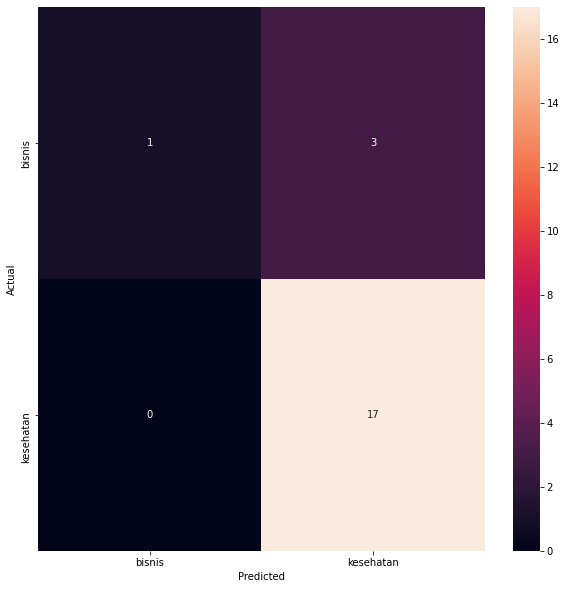

In [24]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
confusion = confusion_matrix(y_test, y_pred,labels=['bisnis','kesehatan'])
print('Confusion Matrix\n')
print(confusion)
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt='d',
            xticklabels=['bisnis','kesehatan'], yticklabels=['bisnis','kesehatan'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
x_tes = []
for i in mlb.inverse_transform(x_test):
    x_tes.append(" ".join(i))
categdf=pd.DataFrame({
                'x_test' : x_tes,
                 'y_true': y_test,
                 'y_pred': y_pred
                })
print(categdf.count())
categdf['correct'] = np.where(categdf['y_true']==categdf['y_pred'], 'benar', 'salah')
display(categdf.style.highlight_max(color='#f00', subset=pd.IndexSlice[:, ['correct']], axis=0))

x_test    21
y_true    21
y_pred    21
dtype: int64


,x_test,y_true,y_pred,correct
30,daripada devand bar akses bel buka buru cloud angkut derita,kesehatan,kesehatan,benar
117,chatting current death buyback aplikasi basah buku baru bahwa blu angkut derita,kesehatan,kesehatan,benar
79,ajb ateh botol banyak akar dapen benah dampak cara adalah bluluk cheng angkut derita,kesehatan,kesehatan,benar
129,cumlaudelulusan aeon beli adalah berekspektasi danapro bor anggun angsur angkut derita,kesehatan,kesehatan,benar
199,cemas cuci auditorium bahwa danapro bor areal anggun angkut derita,kesehatan,kesehatan,benar
139,asnkerentanpakorupsi bloomberg cost bauksit agar baca asperindo cheng angkut derita,kesehatan,kesehatan,benar
212,ct bpjph alvin biarpun bluluk average areal,bisnis,kesehatan,salah
45,bulog akun celaka biar aspal akses danaxtra average bahkan bakal,bisnis,kesehatan,salah
161,android bikin cepat birokrasi beraktifitas benah atau belah ayo banteng adalah desadesa derivatif angkut derita,kesehatan,kesehatan,benar
250,biofuel borong danaq desadesa blasting dia buka cloud angkut derita,kesehatan,kesehatan,benar


In [26]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)
perf_measure(mlb.transform(y_test),y_pred)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Predict the labels of the test set samples
y_pred = classifier.predict(x_test)
# y_pred = np.around(y_pred)
# Build the confusion matrix of our 3-class classification problem
cm = multilabel_confusion_matrix(y_test, y_pred)
# cm_df = pd.DataFrame(cm,
#                      index = ['kesehatan','bisnis'], 
#                      columns = np.array(pd.MultiIndex.from_product(['kesehatan','bisnis'])).tolist())
print(cm)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm[0]+cm[1])
    
#     cm2 = cm[1]
    cm = cm[0]+cm[1]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cm, classes=[['bisnis'], ['kesehatan'], ['kesehatan','bisnis']],
#                       title='Confusion matrix, without normalization')
fig = plot_confusion_matrix(confusion,classes=['bisnis', 'kesehatan'],
                      title='Confusion matrix, without normalization')
plt.show()